-----------------------------------

**Cognition and Computation project**

-----------------------------------

**Student**: Bertipaglia Beatrice Sofia

**Student ID**: 2054766

**Date**: 22 February 2023

------------------------------------

This project wants to exploit a DBN model for its ability to learn an estimation of the probability distribution that have generated the training data, and then reconstruct similar unseen data (in order to remove noise or to neutralize adversarial attacks).

The aim is to prove it useful when paired to a CNN model: firstly corrupted inputs are reconstructed with DBN, then the CNN model will be used to classify reconstructed inputs.

In conclusion, the pair DBN + CNN will prove to make a robust model when dealing with noised inputs, adversarial attacks, or, in general, with corrupted inputs.

# Import and Preprocess data

*TOTAL TIME TO RUN: 30 minutes.*

In [1]:
#@title

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv

import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch.nn.functional as functional
from tqdm.notebook import tqdm

Import the dataset: **EMNIST**.

- Training set: 112.800 images 28x28,
- Test set: 18.800 images 28x28.

The images are grayscale handwritten numbers and digits, belonging to 47 label's classes:

```
dataset_labels = ['0','1','2','3','4','5','6','7','8','9',
 'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
 'a','b','d','e','f','g','h','n','q','r','t']
```

In [2]:
#@title
%%capture

# import datasets
dataset_train = tv.datasets.EMNIST('data/', split='balanced', train=True, download=True,
                                  transform=tv.transforms.Compose([tv.transforms.ToTensor()]))

dataset_test = tv.datasets.EMNIST('data/', split='balanced', train=False, download=True,
                                 transform=tv.transforms.Compose([tv.transforms.ToTensor()]))

# set of ordered labels
dataset_labels = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M',
                 'N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','d','e','f','g','h','n','q','r','t']

Images' pixels are all in a 0-255 range. To ensure that all the features have a similar scale, that is useful to make work properly machine learning models, Min-Max Normalization is applied to training and testing sets. Now all pixels are in the range 0-1.


In [3]:
#@title
# training set
dataset_train.data = dataset_train.data.type(torch.FloatTensor)/255
data_train = dataset_train.data
targ_train = dataset_train.targets

# testing set
dataset_test.data = dataset_test.data.type(torch.FloatTensor)/255
data_test = dataset_test.data
targ_test = dataset_test.targets

To better understand with what we are working, below is shown one example for each class.

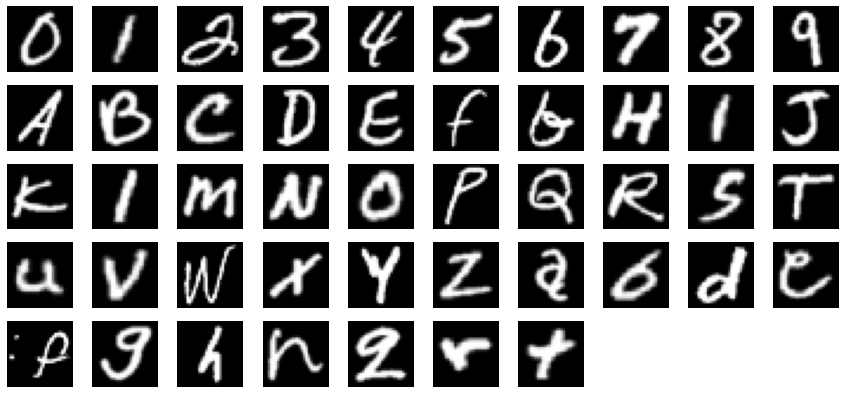

In [4]:
#@title
n_labels = len(dataset_labels)
n_rows = 5

fig, ax = plt.subplots(n_rows, 10, figsize=(15,7))
for i in np.arange(n_rows*10):
  r = i // 10
  c = i % 10
  if i < n_labels:
    # emnist's matrices of images are transposed
    ax[r,c].imshow(torch.transpose(data_train[np.where(targ_train == i)[0][0]], 0, 1), cmap=plt.cm.gray)
    ax[r,c].axis('off')
  else:
    ax[r,c].axis('off')
fig.show()

Are training and testing targets' classes balanced? Yes they are, each set contains more or less 2% of total examples for each class.

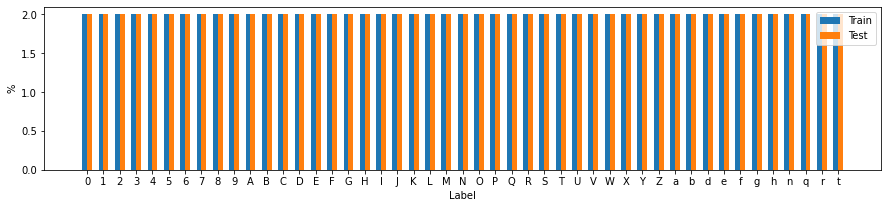

In [5]:
#@title
width = 0.3
fig, ax = plt.subplots(figsize=(15,3))

ax.bar(np.arange(n_labels) - width/2,
      [int(sum(targ_train.numpy() == i) / len(targ_train) * 100) for i in np.arange(n_labels)],
      width, label='Train')
ax.bar(np.arange(n_labels) + width/2,
      [int(sum(targ_test.numpy() == i) / len(targ_test) * 100) for i in np.arange(n_labels)],
      width, label='Test')

plt.xticks(np.arange(n_labels), dataset_labels)
ax.set_xlabel('Label')
ax.set_ylabel('%')
ax.legend()
plt.show()

# Models trained

## DBN
A Deep Belief Network is made by a stack of Restricted Boltzmann Machines, whose goal is to learn the probability distribution that could have generated the training data. It uses many hidden layers to learn a hierarchical generative model (compute hidden representations and also generate prototypical examples of specific classes).

In [6]:
#@title
%%capture

def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}
get_dbn_library()

from DBN import DBN

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data_train = data_train.to(device)
targ_train = targ_train.to(device)
data_test = data_test.to(device)
targ_test = targ_test.to(device)

The model trained is a Deep Belief Network (using PyTorch) with three hidden layers, respectively composed of 400, 500 and 800 units. 

In [7]:
#@title
dbn_model = DBN(visible_units=28*28,
                hidden_units=[400, 500, 800],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

This network is trained on the training set, 100 epochs are done for each of the three stacked RBMs and batches composed of 256 examples are considered in the training. Its performance will be analyzed afterwards.

In [8]:
#@title
num_epochs = 100
batch_size = 256

dbn_model.train_static(data_train,
                       targ_train,
                       num_epochs,
                       batch_size)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |2.6850     |0.0600       |271.8970   |4.6768     |
|20    |2.5334     |0.0540       |255.0259   |4.5332     |
|30    |2.4898     |0.0532       |248.7091   |3.6707     |
|40    |2.4737     |0.0506       |247.8222   |4.2154     |
|50    |2.4598     |0.0512       |246.2908   |3.8470     |
|60    |2.4506     |0.0526       |244.1581   |3.9348     |
|70    |2.4474     |0.0514       |243.0751   |4.0433     |
|80    |2.4467     |0.0521       |242.7881   |3.8162     |
|90    |2.4419     |0.0499       |241.7144   |4.0733     |
|100    |2.4389     |0.0532       |241.3476   |4.4067     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |3.5380     |0.0633       |190.4490   |2.8505     |
|20    |3.3315     |0.0571       |183.3355   |2.7928     |
|30    |3.3032     |0.0567       |181.5274   |2.7850     |
|40    |3.2813     |0.0616      

## CNN

A Convolutional Neural Network is often the most obvious choice when dealing with images.

It may be interesting to analyze how CNN's internal representations of data are and if they become increasingly more disentangled with depth, in comparison to DBN's ones. Are CNNs, compared to DBNs, more or less robust to noise perturbations and more or less resistant to adversarial attacks?

### Noised samples

Let's start by analyzing the robustness of a CNN when noise is injected on data. 

Noisy inputs are obtained by adding some gaussian noise to input data. A noise level can be used to modify the amount of noise added to the data. New data sets are defined by adding different levels of noise to examples. The new sets will be composed of:
- 3/18 (16.67%) of real examples,
- 3/18 (16.67%) of examples with 0.1 of noise level,
- 3/18 (16.67%) of examples with 0.2 of noise level,
- 2/18 (11.11%) of examples with 0.3 of noise level,
- 2/18 (11.11%) of examples with 0.4 of noise level,
- 2/18 (11.11%) of examples with 0.5 of noise level,
- 1/18 (5.56%) of examples with 0.6 of noise level,
- 1/18 (5.56%) of examples with 0.7 of noise level,
- 1/18 (5.56%) of examples with 0.8 of noise level.

The thought behind the creation of this dataset was to be able to analyze at once different levels of noise on images' classification, but at the same time not having a data set composed of too many "strongly noised" images that can create too much difficulty.


In [9]:
#@title

def inject_noise(data, noise_level):
  
  random_gaussian_tensor = torch.randn(data.shape, device=device)*noise_level
  return data + random_gaussian_tensor

def inject_noise_on_data(data):

  noise_levels = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
  start_interval = 0
  end_interval = 0
  new_data = torch.tensor([])

  for n in np.arange(9):

    start_interval = end_interval
    interval = (3 - n//3) * int(data.shape[0]/18)
    end_interval += interval
    
    noised_interval = inject_noise(data[start_interval:end_interval,:], noise_levels[n])
    new_data = torch.cat((new_data, noised_interval.cpu()), 0)

  if end_interval < data.shape[0]:
    new_data = torch.cat((new_data, data.cpu()[end_interval:data.shape[0]]), 0)

  return new_data

Below are shown random real examples (first row) and the correspondent noised examples (second row) to see how data sets are modified.

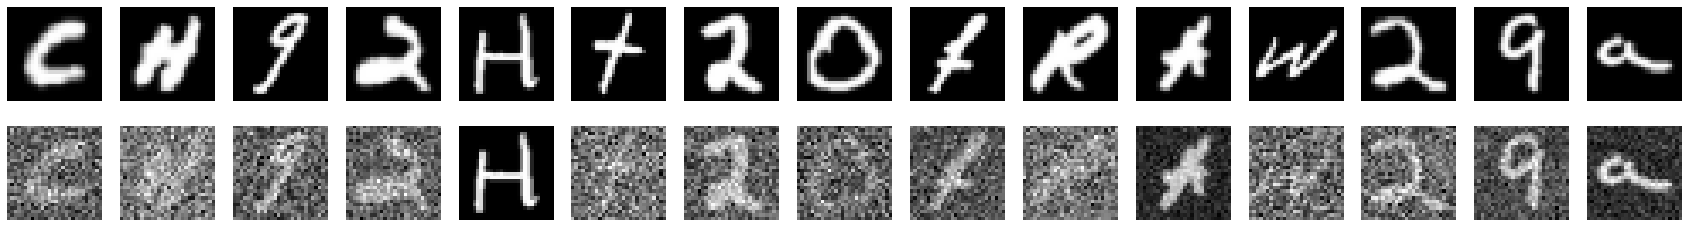

In [10]:
#@title
import random

fig, ax = plt.subplots(2, 15, figsize=(30, 4))
for i in np.arange(15):

  index = random.randint(0, data_train.shape[0]-1)

  ax[0,i].imshow(torch.transpose(data_train.cpu()[index], 0, 1), cmap=plt.cm.gray)
  ax[0,i].axis('off')
  ax[1,i].imshow(torch.transpose(inject_noise_on_data(data_train).cpu()[index], 0, 1), cmap=plt.cm.gray)
  ax[1,i].axis('off')

fig.show()

### CNN: classify real and noised samples

A CNN is a deep network that has at least one convolutional layer, in which neurons are not fully connected with the preceding layer but have local receptive fields, usually followed by a pooling layer, that reduce the dimensionality of the hidden representation and emphasize the most salient features. 

First of all, training "train" set is splitted in training set (85% of training examples, called "train_train" to distinguish it) and validation set (15% of training examples, called "train_val"). Convolutional Neural Networks, indeed, need a validation set for the training phase.

In [11]:
#@title
data_train_train = data_train[:95880, :]
targ_train_train = targ_train[:95880]
data_train_val = data_train[95880:, :]
targ_train_val = targ_train[95880:]

To analyze the ability of a CNN to be robust, noise is injected on training, validation and testing sets, using the method described before.

In [12]:
#@title
data_train_train_noise = inject_noise_on_data(data_train_train)
data_train_val_noise = inject_noise_on_data(data_train_val)
data_test_noise = inject_noise_on_data(data_test)

A deep Convolutional Neural Network is, then, defined (on tensorflow) in the following way:
- two 2D convolutional layers with 28 filters with kernel size 3x3, that use padding and ReLU activation function,
- a Max Pooling layer (2D) of size 2x2,
- a Dropout layer with rate 0.5,
- two 2D convolutional layers with 56 filters with kernel size 3x3, that use padding and ReLU activation function,
- a Max Pooling layer (2D) of size 2x2,
- a Dropout layer with rate 0.5
- two 2D convolutional layers with 112 filters with kernel size 3x3, that use padding and ReLU activation function,
- a Max Pooling layer (2D) of size 2x2,
- a Dropout layer with rate 0.5,
- a Flatten layer and a Dense layer with 47 output neurons that uses Softmax activation function, to get the probabilities of examples to be in each class.

In [13]:
#@title
cnn_model = keras.models.Sequential([
        keras.layers.Conv2D(filters=28, kernel_size=[3, 3], padding="same", activation="relu", input_shape=[28, 28, 1]),
        keras.layers.Conv2D(filters=28, kernel_size=[3, 3], padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2,2)),
        keras.layers.Dropout(0.5),
        keras.layers.Conv2D(filters=56, kernel_size=[3, 3], padding="same", activation="relu"),
        keras.layers.Conv2D(filters=56, kernel_size=[3, 3], padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2,2)),
        keras.layers.Dropout(0.5),
        keras.layers.Conv2D(filters=112, kernel_size=[3, 3], padding="same", activation="relu"),
        keras.layers.Conv2D(filters=112, kernel_size=[3, 3], padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2,2)),
        keras.layers.Dropout(0.5),
        keras.layers.Flatten(),
        keras.layers.Dense(47, activation="softmax")
  ])

The loss to be minimized is the Sparse Categorical Crossentropy, the optimization algorithm to do so is Adam. 

The model is trained on the train_train set and validated on the train_val set, for 100 epochs. Early Stopping is added to allow to train only on the required epochs and to reduce overfitting, working together with pooling and dropout layers. Batches of size 256 are used.

In [14]:
#@title
cnn_model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

callbacks = keras.callbacks.EarlyStopping(patience=4)

history = cnn_model.fit(data_train_train.cpu().numpy(), targ_train_train.cpu().numpy(), epochs=100, batch_size=256,
                            validation_data=(data_train_val.cpu().numpy(), targ_train_val.cpu().numpy()), callbacks=callbacks)

Epoch 1/100
375/375 [==============================] - 18s 24ms/step - loss: 1.3407 - accuracy: 0.6074 - val_loss: 0.4599 - val_accuracy: 0.8389
Epoch 2/100
375/375 [==============================] - 9s 23ms/step - loss: 0.5618 - accuracy: 0.8139 - val_loss: 0.3866 - val_accuracy: 0.8596
Epoch 3/100
375/375 [==============================] - 8s 22ms/step - loss: 0.4736 - accuracy: 0.8371 - val_loss: 0.3456 - val_accuracy: 0.8727
Epoch 4/100
375/375 [==============================] - 9s 25ms/step - loss: 0.4257 - accuracy: 0.8517 - val_loss: 0.3304 - val_accuracy: 0.8780
Epoch 5/100
375/375 [==============================] - 8s 22ms/step - loss: 0.4030 - accuracy: 0.8590 - val_loss: 0.3176 - val_accuracy: 0.8784
Epoch 6/100
375/375 [==============================] - 8s 22ms/step - loss: 0.3858 - accuracy: 0.8635 - val_loss: 0.3095 - val_accuracy: 0.8826
Epoch 7/100
375/375 [==============================] - 9s 25ms/step - loss: 0.3711 - accuracy: 0.8686 - val_loss: 0.3101 - val_accuracy

The training stopped at the end of epoch 23, with the following losses and accuracies on train_train and train_val sets:
```
Epoch 23/100
375/375 [==============================] - 8s 21ms/step - loss: 0.2928 - accuracy: 0.8893 - val_loss: 0.2852 - val_accuracy: 0.8938
```
The performance of this model is then evaluated on the real test set and on the build noised test set.

In [15]:
#@title
print("CNN evaluated on real test data")
scores = cnn_model.evaluate(data_test.cpu().numpy(), targ_test.cpu().numpy(), verbose=2)
print(" %s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))
print("----------------------------")
print("CNN evaluated on noised test data")
scores = cnn_model.evaluate(data_test_noise.cpu().numpy(), targ_test.cpu().numpy(), verbose=2)
print(" %s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))
print("----------------------------")

CNN evaluated on real test data
588/588 - 2s - loss: 0.3054 - accuracy: 0.8929 - 2s/epoch - 3ms/step
 accuracy: 89.29%
----------------------------
CNN evaluated on noised test data
588/588 - 2s - loss: 3.6473 - accuracy: 0.3935 - 2s/epoch - 3ms/step
 accuracy: 39.35%
----------------------------


It's obvious that the CNN model is good at classifying images only if it is working on clear images, when a small quantity of noise is present the model can't predict the correct labels anymore. This is a problem because the final model is not robust and probably won't be good at classifying unseen examples.

## DBN + CNN

A solution to this problem may be exploiting a DBN model for its ability to denoise input data (it is a hierarchical generative model), all this before using the CNN model to classify the DBN-reconstructed inputs.

### DBN: reconstruct noised samples

A new DBN has to be trained.

Giving the fact that it can have the same structure as the one trained before and it will be used only to make reconstructions (never re-trained or fine-tuned), the DBN model already trained on the whole train set is used. This won't positively affect the performance of the DBN model, so the future comparisons will be fair.

This won't positively affect the performance of the CNN model trained only on the train_train set because, also this model, won't be re-trained or fine-tuned (this may has been a possibility with a DBN trained only on the train_train set, it may be a future development of this project).

Below are shown random real examples (first row), the correspondent noised examples (second row), and the DBN-reconstructed examples from the noised ones (third row).

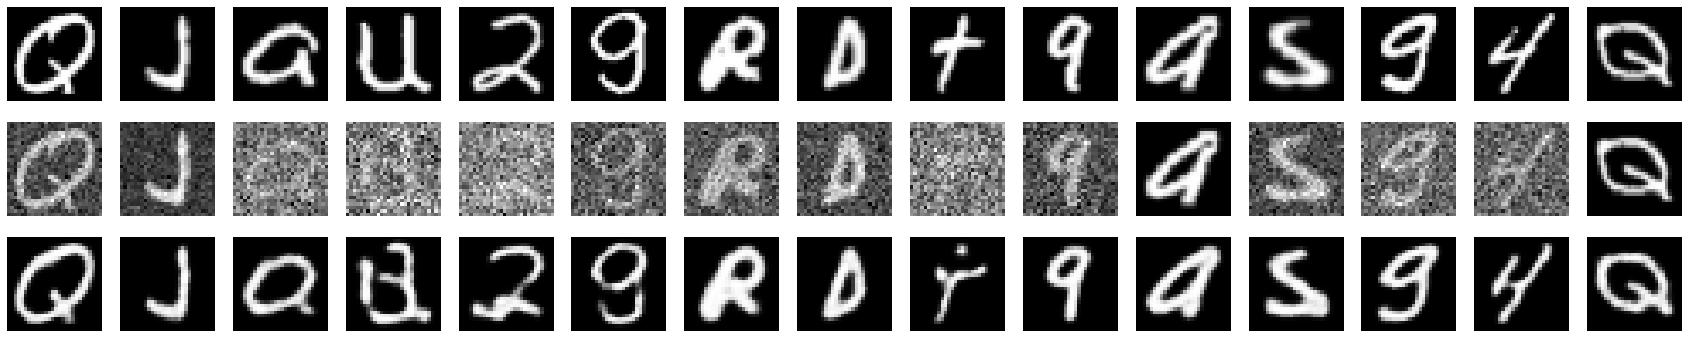

In [70]:
#@title
fig, ax = plt.subplots(3, 15, figsize=(30, 6))
for i in np.arange(15):

  index = random.randint(0, data_train_train.shape[0]-1)

  ax[0,i].imshow(torch.transpose(data_train_train.cpu()[index], 0, 1), cmap=plt.cm.gray)
  ax[0,i].axis('off')
  ax[1,i].imshow(torch.transpose(data_train_train_noise[index], 0, 1), cmap=plt.cm.gray)
  ax[1,i].axis('off')

  # reconstruction
  rec = dbn_model.reconstruct(data_train_train_noise[index].reshape(-1, 784))[0].cpu().detach().numpy().reshape(28, 28).T
  ax[2,i].imshow(rec, cmap=plt.cm.gray)
  ax[2,i].axis('off')

fig.show()

It's clear that the DBN is really good at reconstructing altered images, this is because it learned an estimation of the probability distribution that generated the training input data.

### CNN: classify reconstructed samples

Firstly, noised unseen test data is reconstructed using the DBN model.

In [17]:
#@title
data_test_dbn_rec = dbn_model.reconstruct(data_test_noise.reshape(-1, 784))[0]
data_test_reconstructed = data_test_dbn_rec.cpu().detach().numpy().reshape(data_test.shape[0], 28, 28)

Then, the performance of the already trained CNN at classifying those DBN-reconstructed unseen data is evaluated.

In [18]:
#@title
print("CNN evaluated on real test data")
scores = cnn_model.evaluate(data_test.cpu().numpy(), targ_test.cpu().numpy(), verbose=2)
print(" %s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))
print("----------------------------")
print("CNN evaluated on noised test data")
scores = cnn_model.evaluate(data_test_noise.cpu().numpy(), targ_test.cpu().numpy(), verbose=2)
print(" %s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))
print("----------------------------")
print("CNN evaluated on DBN-reconstructed test data")
scores = cnn_model.evaluate(data_test_reconstructed, targ_test.cpu().numpy(), verbose=2)
print(" %s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))
print("----------------------------")

CNN evaluated on real test data
588/588 - 2s - loss: 0.3054 - accuracy: 0.8929 - 2s/epoch - 3ms/step
 accuracy: 89.29%
----------------------------
CNN evaluated on noised test data
588/588 - 2s - loss: 3.6473 - accuracy: 0.3935 - 2s/epoch - 3ms/step
 accuracy: 39.35%
----------------------------
CNN evaluated on DBN-reconstructed test data
588/588 - 2s - loss: 0.6223 - accuracy: 0.8167 - 2s/epoch - 4ms/step
 accuracy: 81.67%
----------------------------


CNN's performance at classifying DBN-reconstructed data is not as good as its performance at classifying real data, but it is comparable. The difference between accuracies at evaluating noised samples and DBN-reconstructed ones is obvious, the DBN model was very helpful in the CNN's classification of noisy images task.

# Analysis of internal representations

Then, the properties of the learned representations are analyzed. Therefore, the centroid of the representations learned for each class is computed, to see how close they are one to the other using a standard hierarchical clustering algorithm.

-----------------------
**DEEP BELIEF NETWORK**

The 3 hidden representations of the DBN model are computed, using the weights of each RBM contained in the DBN.

In [21]:
#@title
def get_kth_layer_repr(input, k):
  flattened_input = input.view((input.shape[0], -1))
  hidden_repr, __ = dbn_model.rbm_layers[k].to_hidden(flattened_input)
  return hidden_repr

hidden_repr_layer_1 = get_kth_layer_repr(data_train, 0)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2)

The centroid of the hidden representations of each class is computed, and then a matrix containing all the centroids is built to comply with the input required by the clustering algorithm.

In [22]:
#@title
def get_mask(label, targets):
  labels = targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation, targets):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label, targets)].mean(axis=0)
    for label in range(47)
  }

def get_hidden_reprs_matrix(hidden_representation, targets):
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation, targets)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)
    for label in range(47)])
  
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1, targ_train)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2, targ_train)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3, targ_train)

Lastly, the clustering algorithm is runned and its output is visualized in a dendrogram plot.

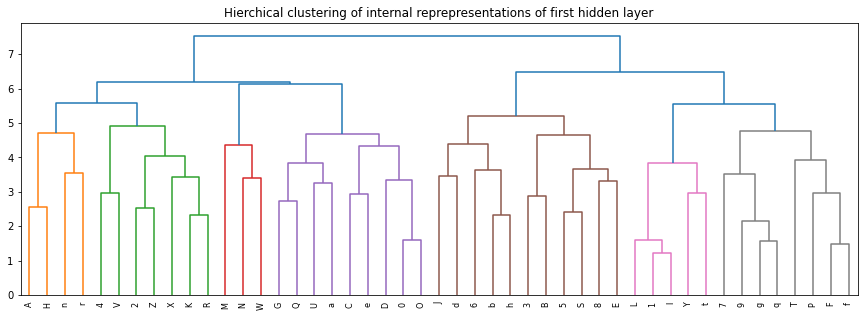

In [23]:
#@title
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots(figsize=(15,5))
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels=dataset_labels)
  ax.set_title(title)

plot_dendrogram(mean_hidd_repr_matrix_1, "Hierchical clustering of internal reprepresentations of first hidden layer")

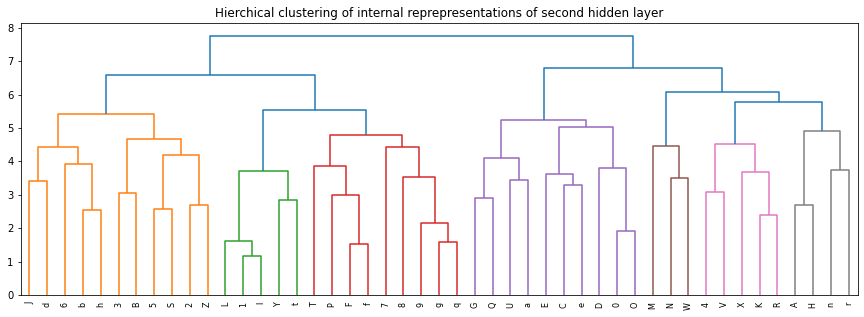

In [24]:
#@title
plot_dendrogram(mean_hidd_repr_matrix_2, "Hierchical clustering of internal reprepresentations of second hidden layer")

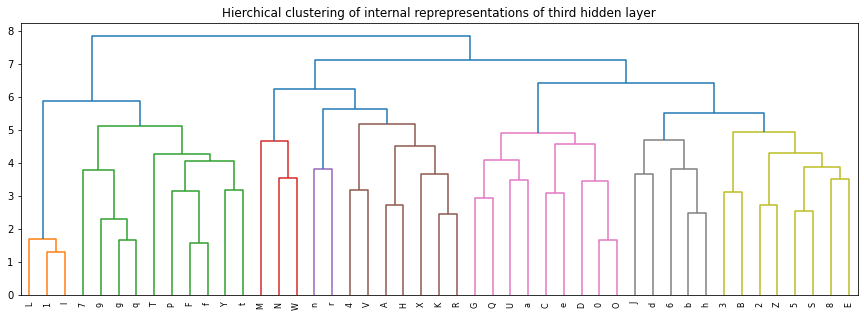

In [25]:
#@title
plot_dendrogram(mean_hidd_repr_matrix_3, "Hierchical clustering of internal reprepresentations of third hidden layer")

It can be seen that the hierchical clustering of 1st, 2nd and 3rd RBM internal representations clusters together more or less the same classes. For example "0" "O" "D" classes are near in all the 3 clusterings, same for "L" "1" "I", "F" "f", etc.

The explanation behind is that those digits and letters are very similar visually, so they will be similar even in distribution.

From this fact it can be seen that each RBM alone is able to get a good understanding of the input data, and is able to efficiently represent it.

-----------------------------------
**CONVOLUTIONAL NEURAL NETWORK**

The procedure for obtaining hierchical clustering for the CNN model is similar as the one for the DBN model.

The hidden representations of the CNN are a lot more (it has way more layers than the ones of the DBN), so it has to be chosen which ones to analyze. Looking at the composition of the CNN model (explained before) a good choice is to analyze the hidden representations obtained after each of the 3 Dropout layers.

The problem is that those hidden representations are way "bigger" than the DBN's ones (vectors of 400, 500 and 800 values), those are vectors of 5488 (14x14x28), 2744 (7x7x56) and 1008 values (3x3x112). Those vectors may be computed but would be memory expensive.

A solution consists in flattening those tensors and averaging values by blocks of 7, 4 and 2 respectively. The ending result are 3 hidden representations composed of vectors of 784, 686, and 504 values. This is still a problem because much information is lost, but it is a preferred one in this case.

Alike DBN, the previous hidden representation cannot be used for obtaining the next one because too much information would be lost (but could have been used if the hidden representation had not been reduced in size).

In [26]:
#@title
def get_1_dropoutlayer_repr(input):

  hidden_repr_dropout1 = keras.models.Sequential([
          keras.layers.Conv2D(filters=28, kernel_size=[3, 3], padding="same", activation="relu", input_shape=[28, 28, 1]), #(28x28)x28
          keras.layers.Conv2D(filters=28, kernel_size=[3, 3], padding="same", activation="relu"), #(28x28)x28
          keras.layers.MaxPool2D(pool_size=(2,2)), #(14x14)x28
          keras.layers.Dropout(0.5), #(14x14)x28 = 5488 ---> too many

          # new layers to reduce the number of parameters
          keras.layers.Reshape((5488, 1)),
          keras.layers.AvgPool1D(pool_size=7, strides=7),
          keras.layers.Flatten() # 784 parameters
          ])
  
  # use the learned parameters of the complete cnn model
  hidden_repr_dropout1.layers[0].set_weights(cnn_model.layers[0].get_weights())
  hidden_repr_dropout1.layers[1].set_weights(cnn_model.layers[1].get_weights())
  
  return hidden_repr_dropout1.predict(input.cpu().numpy(), verbose=0)

In [27]:
#@title
def get_2_dropoutlayer_repr(input):

  hidden_repr_dropout2 = keras.models.Sequential([
          keras.layers.Conv2D(filters=28, kernel_size=[3, 3], padding="same", activation="relu", input_shape=[28, 28, 1]), #(28x28)x28
          keras.layers.Conv2D(filters=28, kernel_size=[3, 3], padding="same", activation="relu"), #(28x28)x28
          keras.layers.MaxPool2D(pool_size=(2,2)), #(14x14)x28
          keras.layers.Dropout(0.5), #(14x14)x28
          keras.layers.Conv2D(filters=56, kernel_size=[3, 3], padding="same", activation="relu"), #(14x14)x56
          keras.layers.Conv2D(filters=56, kernel_size=[3, 3], padding="same", activation="relu"), #(14x14)x56
          keras.layers.MaxPool2D(pool_size=(2,2)), #(7x7)x56
          keras.layers.Dropout(0.5), #(7x7)x56 = 2744 ---> too many

          # new pooling layer to reduce the number of parameters
          keras.layers.Reshape((2744, 1)),
          keras.layers.AvgPool1D(pool_size=4, strides=4),
          keras.layers.Flatten() # 686 parameters
          ])

  # use the learned parameters of the complete cnn model
  hidden_repr_dropout2.layers[0].set_weights(cnn_model.layers[0].get_weights())
  hidden_repr_dropout2.layers[1].set_weights(cnn_model.layers[1].get_weights())
  hidden_repr_dropout2.layers[4].set_weights(cnn_model.layers[4].get_weights())
  hidden_repr_dropout2.layers[5].set_weights(cnn_model.layers[5].get_weights())

  return hidden_repr_dropout2.predict(input.cpu().numpy(), verbose=0)

In [28]:
#@title
def get_3_dropoutlayer_repr(input):

  hidden_repr_dropout3 = keras.models.Sequential([
          keras.layers.Conv2D(filters=28, kernel_size=[3, 3], padding="same", activation="relu", input_shape=[28, 28, 1]), #(28x28)x28
          keras.layers.Conv2D(filters=28, kernel_size=[3, 3], padding="same", activation="relu"), #(28x28)x28
          keras.layers.MaxPool2D(pool_size=(2,2)), #(14x14)x28
          keras.layers.Dropout(0.5), #(14x14)x28
          keras.layers.Conv2D(filters=56, kernel_size=[3, 3], padding="same", activation="relu"), #(14x14)x56
          keras.layers.Conv2D(filters=56, kernel_size=[3, 3], padding="same", activation="relu"), #(14x14)x56
          keras.layers.MaxPool2D(pool_size=(2,2)), #(7x7)x56
          keras.layers.Dropout(0.5), #(7x7)x56
          keras.layers.Conv2D(filters=112, kernel_size=[3, 3], padding="same", activation="relu"), #(7x7)x112
          keras.layers.Conv2D(filters=112, kernel_size=[3, 3], padding="same", activation="relu"), #(7x7)x112
          keras.layers.MaxPool2D(pool_size=(2,2)), #(3x3)x112
          keras.layers.Dropout(0.5), #(3x3)x112 = 1008

          # new pooling layer to reduce the number of parameters
          keras.layers.Reshape((1008, 1)),
          keras.layers.AvgPool1D(pool_size=2, strides=2),
          keras.layers.Flatten() # 504
          ])

  # use the learned parameters of the complete cnn model
  hidden_repr_dropout3.layers[0].set_weights(cnn_model.layers[0].get_weights())
  hidden_repr_dropout3.layers[1].set_weights(cnn_model.layers[1].get_weights())
  hidden_repr_dropout3.layers[4].set_weights(cnn_model.layers[4].get_weights())
  hidden_repr_dropout3.layers[5].set_weights(cnn_model.layers[5].get_weights())
  hidden_repr_dropout3.layers[8].set_weights(cnn_model.layers[8].get_weights())
  hidden_repr_dropout3.layers[9].set_weights(cnn_model.layers[9].get_weights())

  return hidden_repr_dropout3.predict(input.cpu().detach().numpy(), verbose=0)

Same procedure as before to obtain dendrograms showing hierchical clusterings.

In [29]:
#@title
hidden_repr_layer_dropout1 = get_1_dropoutlayer_repr(data_train_train)
hidden_repr_layer_dropout2 = get_2_dropoutlayer_repr(data_train_train)
hidden_repr_layer_dropout3 = get_3_dropoutlayer_repr(data_train_train)

def get_label_to_mean_hidd_repr_cnn(hidden_representation, targets):
  hidden_representation_np = hidden_representation
  return {
    label: hidden_representation_np[get_mask(label, targets)].mean(axis=0)
    for label in range(47)
  }

def get_hidden_reprs_matrix_cnn(hidden_representation, targets):
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr_cnn(hidden_representation, targets)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)
    for label in range(47)])
  
mean_hidd_repr_matrix_dropout1 = get_hidden_reprs_matrix_cnn(hidden_repr_layer_dropout1, targ_train_train)
mean_hidd_repr_matrix_dropout2 = get_hidden_reprs_matrix_cnn(hidden_repr_layer_dropout2, targ_train_train)
mean_hidd_repr_matrix_dropout3 = get_hidden_reprs_matrix_cnn(hidden_repr_layer_dropout3, targ_train_train)

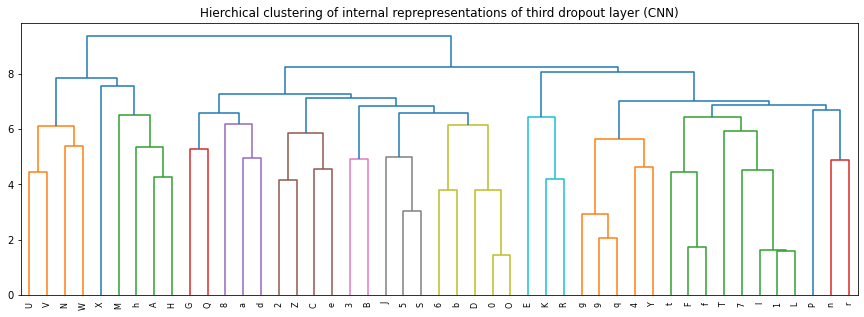

In [30]:
#@title
# plot_dendrogram(mean_hidd_repr_matrix_dropout1, "Hierchical clustering of internal reprepresentations of first dropout layer (CNN)")
# plot_dendrogram(mean_hidd_repr_matrix_dropout1, "Hierchical clustering of internal reprepresentations of second dropout layer (CNN)")
plot_dendrogram(mean_hidd_repr_matrix_dropout3, "Hierchical clustering of internal reprepresentations of third dropout layer (CNN)")

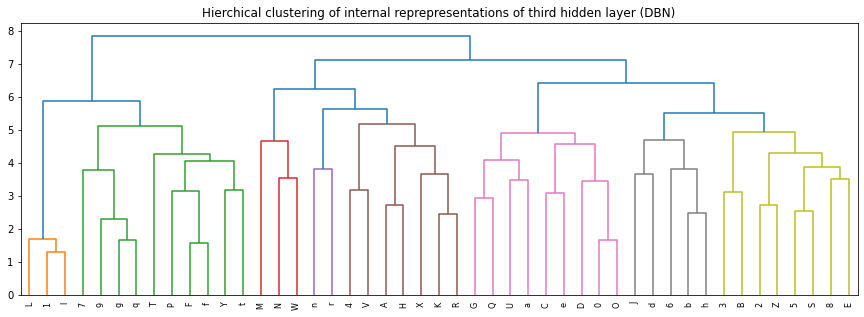

In [31]:
#@title
plot_dendrogram(mean_hidd_repr_matrix_3, "Hierchical clustering of internal reprepresentations of third hidden layer (DBN)")

In comparison the hierchical clustering obtained from internal representations of CNN is more complex with respect to the one obtained from internal representations of DBN. This may will result in a better performance of the CNN w.r.t. DBN.

Anyway, there are several similarities in the final clusters, "L" "1" "I" are always near, "O" "0" "D" also, etc.

# Linear read-outs at different layers

The interest, now, is put on analyzing each model ability to well represent images in hidden layers.

This ability is analyzed by evaluating the performance of a linear classifier in the task of classifying each image's hidden representation (input of the linear model) to the respective correct image's label (output of the linear model).

This is a way to assess how much information is contained in each hidden representatation.

Firstly, the class for the linear model is defined.

In [32]:
#@title
# linear classifier
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 47)

  def forward(self, x):
    return self.linear(x)

-----------------------
**DEEP BELIEF NETWORK**

A linear classifier for each layer of the DBN is created. 

In [33]:
#@title
layer_size = dbn_model.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_model.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_model.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

Then, the linear classifiers are trained on the hidden representations (of the train set) from each layer using the actual labels as targets.

In [34]:
#@title
def train_linear(linear, hidden_reprs, targets_train):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 1500

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = targets_train.reshape(predictions.shape[0])
    loss = loss_fn(predictions, targets)
    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))
      

train_linear(linear1, hidden_repr_layer_1, targ_train)

epoch :   1/1500, loss = 3.9047
epoch : 101/1500, loss = 2.9655
epoch : 201/1500, loss = 2.4230
epoch : 301/1500, loss = 2.0955
epoch : 401/1500, loss = 1.8872
epoch : 501/1500, loss = 1.7462
epoch : 601/1500, loss = 1.6449
epoch : 701/1500, loss = 1.5683
epoch : 801/1500, loss = 1.5080
epoch : 901/1500, loss = 1.4589
epoch : 1001/1500, loss = 1.4180
epoch : 1101/1500, loss = 1.3830
epoch : 1201/1500, loss = 1.3527
epoch : 1301/1500, loss = 1.3261
epoch : 1401/1500, loss = 1.3024


In [35]:
#@title
train_linear(linear2, hidden_repr_layer_2, targ_train)

epoch :   1/1500, loss = 3.8926
epoch : 101/1500, loss = 2.9130
epoch : 201/1500, loss = 2.3690
epoch : 301/1500, loss = 2.0543
epoch : 401/1500, loss = 1.8590
epoch : 501/1500, loss = 1.7280
epoch : 601/1500, loss = 1.6340
epoch : 701/1500, loss = 1.5627
epoch : 801/1500, loss = 1.5064
epoch : 901/1500, loss = 1.4604
epoch : 1001/1500, loss = 1.4218
epoch : 1101/1500, loss = 1.3888
epoch : 1201/1500, loss = 1.3600
epoch : 1301/1500, loss = 1.3347
epoch : 1401/1500, loss = 1.3121


In [36]:
#@title
train_linear(linear3, hidden_repr_layer_3, targ_train)

epoch :   1/1500, loss = 3.8690
epoch : 101/1500, loss = 2.8640
epoch : 201/1500, loss = 2.2992
epoch : 301/1500, loss = 1.9734
epoch : 401/1500, loss = 1.7725
epoch : 501/1500, loss = 1.6385
epoch : 601/1500, loss = 1.5425
epoch : 701/1500, loss = 1.4699
epoch : 801/1500, loss = 1.4124
epoch : 901/1500, loss = 1.3655
epoch : 1001/1500, loss = 1.3260
epoch : 1101/1500, loss = 1.2922
epoch : 1201/1500, loss = 1.2627
epoch : 1301/1500, loss = 1.2367
epoch : 1401/1500, loss = 1.2135


Now hidden representations for the test set have to be build, they are used to evaluate the trained linear readouts.

In [37]:
#@title
# built hidden representations
hidden_repr_layer_1_test = get_kth_layer_repr(data_test, 0)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2)

# compute their predictions
predictions_dbn1 = linear1(hidden_repr_layer_1_test)
predictions_dbn2 = linear2(hidden_repr_layer_2_test)
predictions_dbn3 = linear3(hidden_repr_layer_3_test)

Finally, the accuracy scores are computed.

In [38]:
#@title
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

print("Accuracy for 1st hidden layer: ",  round(compute_accuracy(predictions_dbn1, targ_test)*100, 2), "%")
print("Accuracy for 2nd hidden layer: ",  round(compute_accuracy(predictions_dbn2, targ_test)*100, 2), "%")
print("Accuracy for 3rd hidden layer: ",  round(compute_accuracy(predictions_dbn3, targ_test)*100, 2), "%")

Accuracy for 1st hidden layer:  65.88 %
Accuracy for 2nd hidden layer:  65.4 %
Accuracy for 3rd hidden layer:  68.09 %


As it can be seen there is not much difference between internal representations, they carry more or less the same amount of information. This is good because it means that information were not lost in the process.

At the same time accuracy for third hidden layer is a little higher than the ones before, so sensory representations become more disentangled at the deepest layer of the network.

-------------------------------
**CONVOLUTIONA NEURAL NETWORK**

A linear classifier for each layer of the CNN is created.

In [39]:
#@title
linear1_cnn = LinearModel(hidden_repr_layer_dropout1.shape[1]).to(device)
linear2_cnn = LinearModel(hidden_repr_layer_dropout2.shape[1]).to(device)
linear3_cnn = LinearModel(hidden_repr_layer_dropout3.shape[1]).to(device)

Then, the linear classifiers are trained on the hidden representations (of the train_train set) from each layer using the actual labels as targets.

In [40]:
#@title
train_linear(linear1_cnn, torch.tensor(hidden_repr_layer_dropout1).to(device), targ_train_train)

epoch :   1/1500, loss = 3.8506
epoch : 101/1500, loss = 3.8336
epoch : 201/1500, loss = 3.8172
epoch : 301/1500, loss = 3.8012
epoch : 401/1500, loss = 3.7854
epoch : 501/1500, loss = 3.7699
epoch : 601/1500, loss = 3.7546
epoch : 701/1500, loss = 3.7394
epoch : 801/1500, loss = 3.7244
epoch : 901/1500, loss = 3.7095
epoch : 1001/1500, loss = 3.6947
epoch : 1101/1500, loss = 3.6801
epoch : 1201/1500, loss = 3.6655
epoch : 1301/1500, loss = 3.6511
epoch : 1401/1500, loss = 3.6367


In [41]:
#@title
train_linear(linear2_cnn, torch.tensor(hidden_repr_layer_dropout2).to(device), targ_train_train)

epoch :   1/1500, loss = 3.8538
epoch : 101/1500, loss = 3.7222
epoch : 201/1500, loss = 3.6018
epoch : 301/1500, loss = 3.4880
epoch : 401/1500, loss = 3.3790
epoch : 501/1500, loss = 3.2745
epoch : 601/1500, loss = 3.1741
epoch : 701/1500, loss = 3.0778
epoch : 801/1500, loss = 2.9855
epoch : 901/1500, loss = 2.8971
epoch : 1001/1500, loss = 2.8125
epoch : 1101/1500, loss = 2.7317
epoch : 1201/1500, loss = 2.6544
epoch : 1301/1500, loss = 2.5807
epoch : 1401/1500, loss = 2.5104


In [42]:
#@title
train_linear(linear3_cnn, torch.tensor(hidden_repr_layer_dropout3).to(device), targ_train_train)

epoch :   1/1500, loss = 3.8711
epoch : 101/1500, loss = 2.1182
epoch : 201/1500, loss = 1.3057
epoch : 301/1500, loss = 0.9596
epoch : 401/1500, loss = 0.7875
epoch : 501/1500, loss = 0.6871
epoch : 601/1500, loss = 0.6217
epoch : 701/1500, loss = 0.5755
epoch : 801/1500, loss = 0.5410
epoch : 901/1500, loss = 0.5141
epoch : 1001/1500, loss = 0.4926
epoch : 1101/1500, loss = 0.4748
epoch : 1201/1500, loss = 0.4599
epoch : 1301/1500, loss = 0.4471
epoch : 1401/1500, loss = 0.4360


Now hidden representations for the test set have to be build, they are used to evaluate the trained linear readouts.

In [43]:
#@title
# hiddden representations
hidden_repr_layer_dropout1_test = get_1_dropoutlayer_repr(data_test)
hidden_repr_layer_dropout2_test = get_2_dropoutlayer_repr(data_test)
hidden_repr_layer_dropout3_test = get_3_dropoutlayer_repr(data_test)

# compute the predictions
predictions_1_cnn = linear1_cnn(torch.tensor(hidden_repr_layer_dropout1_test).to(device))
predictions_2_cnn = linear2_cnn(torch.tensor(hidden_repr_layer_dropout2_test).to(device))
predictions_3_cnn = linear3_cnn(torch.tensor(hidden_repr_layer_dropout3_test).to(device))

Finally, the accuracy scores are computed.

In [44]:
#@title
print("Accuracy for 1st dropout layer: ",  round(compute_accuracy(predictions_1_cnn, targ_test)*100, 2), "%")
print("Accuracy for 2nd dropout layer: ",  round(compute_accuracy(predictions_2_cnn, targ_test)*100, 2), "%")
print("Accuracy for 3rd dropout layer: ",  round(compute_accuracy(predictions_3_cnn, targ_test)*100, 2), "%")

Accuracy for 1st dropout layer:  40.0 %
Accuracy for 2nd dropout layer:  70.51 %
Accuracy for 3rd dropout layer:  86.91 %


Accuracies for first and second dopout layers should be comparable to accuracy for the third one (more or less 86%). Here they are not because the internal representations were reduced in size averaging between values (for memory reasons), so a lot of information was lost.

## Comparison with a FFNN

Let's now train a simple feed-forward neural network with the same structure of the DBN, in order to compare a non-linear model that is trained end-to-end to solve a classification task with a simple linear classifier that solves the same task using representations of input data learned in an unsupervised way.

In [45]:
#@title
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 47)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

ffnn_model = Feedforward(400, 500, 800).to(device)

Train the FFNN on the train set.

In [46]:
#@title
def train(network, input, epochs=1500):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets = targ_train.reshape(predictions.shape[0])
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

train(ffnn_model, data_train.reshape((data_train.shape[0], 784)), epochs=1500)

epoch :   1/1500, loss = 3.8510
epoch : 101/1500, loss = 3.8372
epoch : 201/1500, loss = 3.8070
epoch : 301/1500, loss = 3.6862
epoch : 401/1500, loss = 3.1137
epoch : 501/1500, loss = 2.3513
epoch : 601/1500, loss = 1.8723
epoch : 701/1500, loss = 1.6403
epoch : 801/1500, loss = 1.5129
epoch : 901/1500, loss = 1.4180
epoch : 1001/1500, loss = 1.3443
epoch : 1101/1500, loss = 1.2825
epoch : 1201/1500, loss = 1.2304
epoch : 1301/1500, loss = 1.1846
epoch : 1401/1500, loss = 1.1427


Make predictions on the test set and compute the accuracy score.

In [47]:
#@title
predictions_ffnn = ffnn_model(data_test.reshape((data_test.shape[0], 784)))

print("Accuracy: ",  round(compute_accuracy(predictions_ffnn, targ_test)*100, 2), "%")

Accuracy:  67.56 %


The FFNN model obtained an accuracy score similar to the ones obtained by the linear classifier that used DBN's representations of input data.

# Visualize errors

Now, some noise is injected in the input images to see how much the representations learned by the models are robust to perturbations in the sensory signal. Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curve describing the decrease in classification accuracy with respect to the noise level.

The hidden representations for the noisy test images are computed for the last hidden layer of DBN (for the sake of comparison with other models only the last is analyzed), the last dropout layer of the CNN (the first two were compromised by memory reduction), and the FNNN.

Also, the hidden representations for the noisy test images are computed for the last dropout layer of the DBN + CNN (simply noisy test images are reconstructed by the DBN, and then hidden representations are computed for the last dropout layer of the CNN).

To see if the DBN-reconstruction of noisy test images benefit also the DBN itself, the hidden representations for the noisy test images are computed for the last hidden layer of the DBN + DBN or "DBN top-down" (simply noisy test images are reconstructed by the DBN, and then hidden representations are computed for the last hidden layer of the DBN)

Then, the read-out classifiers trained on the representations without noise are used to classify the noisy stimuli.

In [48]:
#@title
def get_accuracy_values_at_noise_level(noise_level, data, targets):

  # create noisy test images
  data_test_noise = inject_noise(data, noise_level)
  
  # --------- DBN
  # last hidden layer representation of noisy test images
  hidden_repr_layer_1_noisy_dbn = get_kth_layer_repr(data_test_noise, 0)
  hidden_repr_layer_2_noisy_dbn = get_kth_layer_repr(hidden_repr_layer_1_noisy_dbn, 1)
  hidden_repr_layer_3_noisy_dbn = get_kth_layer_repr(hidden_repr_layer_2_noisy_dbn, 2)
  # read-out classifier to predict their labels
  predictions_third_hidden_noisy_dbn = linear3(hidden_repr_layer_3_noisy_dbn)
  # computation of accuracy and confusion matrix
  acc_3hid_dbn = compute_accuracy(predictions_third_hidden_noisy_dbn, targets)
  conf_matr_dbn = confusion_matrix(targets.cpu(), predictions_third_hidden_noisy_dbn.detach().cpu().max(axis=1).indices)

  # --------- DBN + DBN
  # noisy test images are reconstructed using DBN model
  data_test_dbn_rec = dbn_model.reconstruct(data_test_noise.reshape(-1, 784))[0]
  data_test_reconstructed = data_test_dbn_rec.reshape(data.shape[0], 28, 28) 
  # last hidden layer representation of noisy test images
  hidden_repr_layer_1_noisy_dbndbn = get_kth_layer_repr(data_test_reconstructed, 0)
  hidden_repr_layer_2_noisy_dbndbn = get_kth_layer_repr(hidden_repr_layer_1_noisy_dbndbn, 1)
  hidden_repr_layer_3_noisy_dbndbn = get_kth_layer_repr(hidden_repr_layer_2_noisy_dbndbn, 2)
  # read-out classifier to predict their labels
  predictions_third_hidden_noisy_dbndbn = linear3(hidden_repr_layer_3_noisy_dbndbn)
  # computation of accuracy and confusion matrix
  acc_3hid_dbndbn = compute_accuracy(predictions_third_hidden_noisy_dbndbn, targets)
  conf_matr_dbndbn = confusion_matrix(targets.cpu(), predictions_third_hidden_noisy_dbndbn.detach().cpu().max(axis=1).indices)

  # --------- CNN
  # last dropout layer representation of noisy test images
  repr3_cnn = torch.tensor(get_3_dropoutlayer_repr(data_test_noise)).to(device)
  # read-out classifier to predict their labels
  predictions_third_hidden_noisy_cnn = linear3_cnn(repr3_cnn)
  # computation of accuracy and confusion matrix
  acc_3hid_cnn = compute_accuracy(predictions_third_hidden_noisy_cnn, targets)
  conf_matr_cnn = confusion_matrix(targets.cpu(), predictions_third_hidden_noisy_cnn.detach().cpu().max(axis=1).indices)

  # --------- DBN + CNN
  # noisy test images are reconstructed using DBN model 
  # last dropout layer representation of reconstructed test images
  repr3_dbncnn = torch.tensor(get_3_dropoutlayer_repr(data_test_reconstructed)).to(device)
  # read-out classifier to predict their labels
  predictions_third_hidden_noisy_dbncnn = linear3_cnn(repr3_dbncnn)
  # computation of accuracy and confusion matrix
  acc_3hid_dbncnn = compute_accuracy(predictions_third_hidden_noisy_dbncnn, targets)
  conf_matr_dbncnn = confusion_matrix(targets.cpu(), predictions_third_hidden_noisy_dbncnn.detach().cpu().max(axis=1).indices)

  # --------- FFNN
  # predict noisy test images' labels
  predictions_ffnn_noisy = ffnn_model(data_test_noise.reshape((data.shape[0], 784)))
  # computation of accuracy
  acc_ffnn = compute_accuracy(predictions_ffnn_noisy, targets)

  return acc_3hid_dbn, acc_3hid_dbndbn, acc_3hid_cnn, acc_3hid_dbncnn, acc_ffnn, conf_matr_dbn, conf_matr_dbndbn, conf_matr_cnn, conf_matr_dbncnn

Those are the accuracy scores obtained from this procedure and using a noise level of 0.3 for the test images:

In [49]:
#@title
acc = get_accuracy_values_at_noise_level(0.3, data_test, targ_test)
print("   DBN   : Accuracy of ", round(acc[0]*100, 2),"%")
print("---------------------------------")
print(" DBN+DBN : Accuracy of ", round(acc[1]*100, 2),"%")
print("---------------------------------")
print("   CNN   : Accuracy of ", round(acc[2]*100, 2),"%")
print("---------------------------------")
print(" DBN+CNN : Accuracy of ", round(acc[3]*100, 2),"%")
print("---------------------------------")
print("  FFNN   : Accuracy of ", round(acc[4]*100, 2),"%")

   DBN   : Accuracy of  66.81 %
---------------------------------
 DBN+DBN : Accuracy of  66.96 %
---------------------------------
   CNN   : Accuracy of  26.2 %
---------------------------------
 DBN+CNN : Accuracy of  81.92 %
---------------------------------
  FFNN   : Accuracy of  63.07 %


Psychometric curves (at different levels of noise) are created.

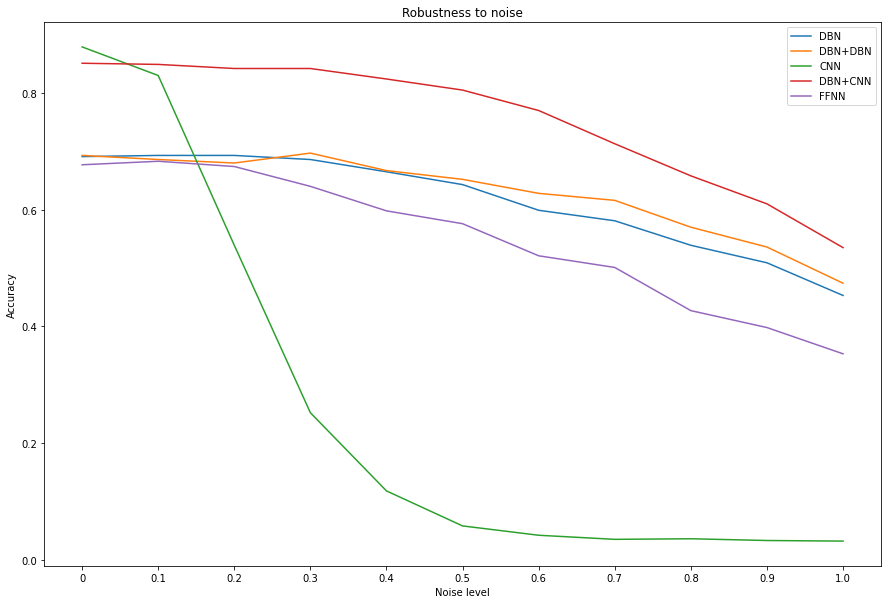

In [50]:
#@title
def plot_noise_robustness_curves(noise_levels):
  acc_3hid_dbn = []
  acc_3hid_dbndbn = []
  acc_3hid_cnn = []
  acc_3hid_dbncnn = []
  acc_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level, data_test[:1000], targ_test[:1000])
    acc_3hid_dbn.append(acc[0])
    acc_3hid_dbndbn.append(acc[1])
    acc_3hid_cnn.append(acc[2])
    acc_3hid_dbncnn.append(acc[3])
    acc_ffnn.append(acc[4])

  fig, ax = plt.subplots()
  fig.set_figheight(10)
  fig.set_figwidth(15)

  ax.plot(range(len(noise_levels)), acc_3hid_dbn)
  ax.plot(range(len(noise_levels)), acc_3hid_dbndbn)
  ax.plot(range(len(noise_levels)), acc_3hid_cnn)
  ax.plot(range(len(noise_levels)), acc_3hid_dbncnn)
  ax.plot(range(len(noise_levels)), acc_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [l for l in noise_levels])
  plt.legend(["DBN", "DBN+DBN", "CNN", "DBN+CNN", "FFNN"])


noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plot_noise_robustness_curves(noise_levels)

As it was saw before, the CNN model is not robust at all. Even with small quantities of noise its performance goes down.

The first step of reconstructing images with DBN is always a good choice when working with CNNs, indeed it made the model robust.

DBN and DBN + DBN are similar, a step of reconstruction do only a very little benefit to the DBN.

Confusion matrices, also, can be visualized.

This is the confusion matrix of the last hidden layer of DBN for a noise level of 0.3 injected in the test set.

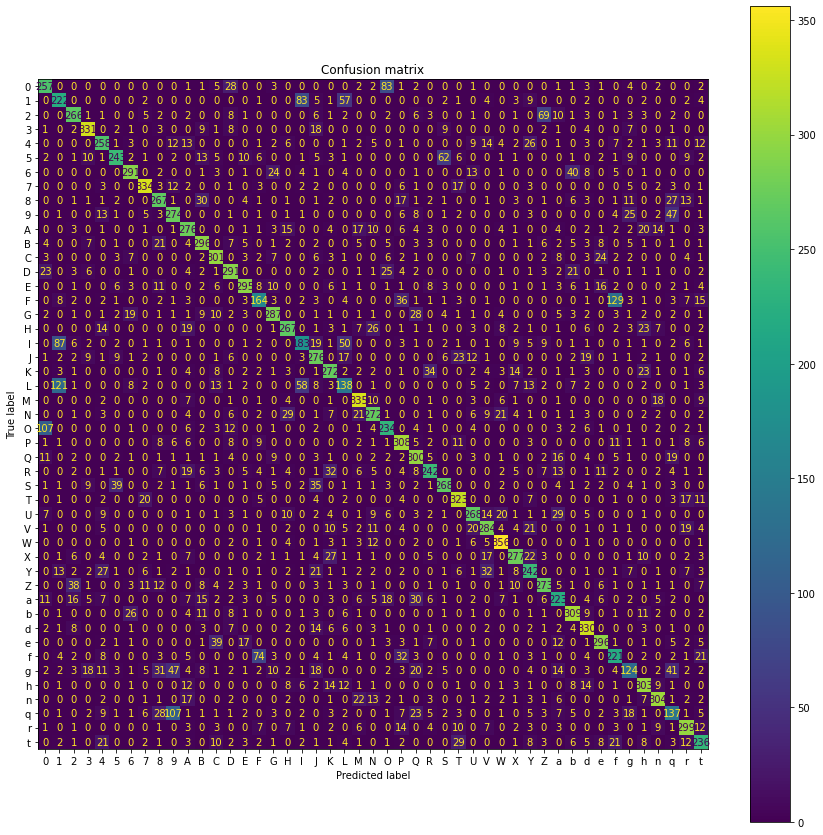

In [51]:
#@title
get_accuracy = get_accuracy_values_at_noise_level(0.3, data_test, targ_test)


def conf_matr(index, acc):
  # index = 5 for DBN, 6 for DBN+DBN, 7 for CNN, 8 for DBN+CNN
  conf_matr = acc[index]
  conf_matr_displ = ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=dataset_labels)
  fig, ax = plt.subplots(figsize=(15, 15))
  conf_matr_displ.plot(ax = ax)
  plt.title('Confusion matrix')
  plt.show()


# DBN
conf_matr(5, get_accuracy)

This is the confusion matrix of the last dropout layer of CNN for a noise level of 0.3 injected in the test set.

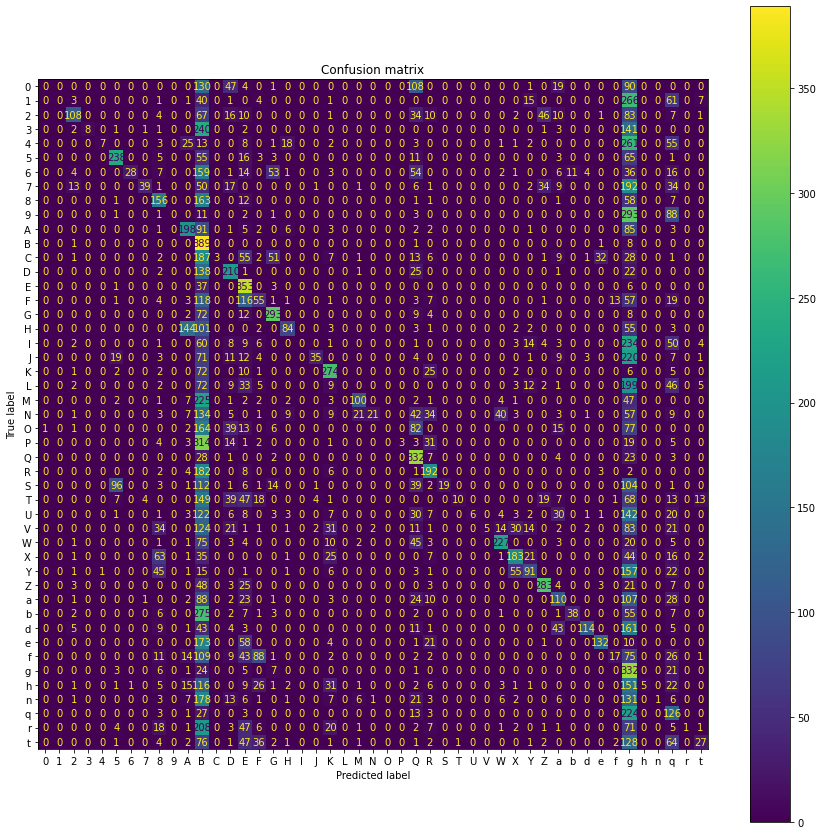

In [52]:
#@title
# CNN
conf_matr(7, get_accuracy)

This is the confusion matrix of the last dropout layer of CNN for a noise level of 0.3 injected in the test set, test set that is DBN-recostructed before the classification.

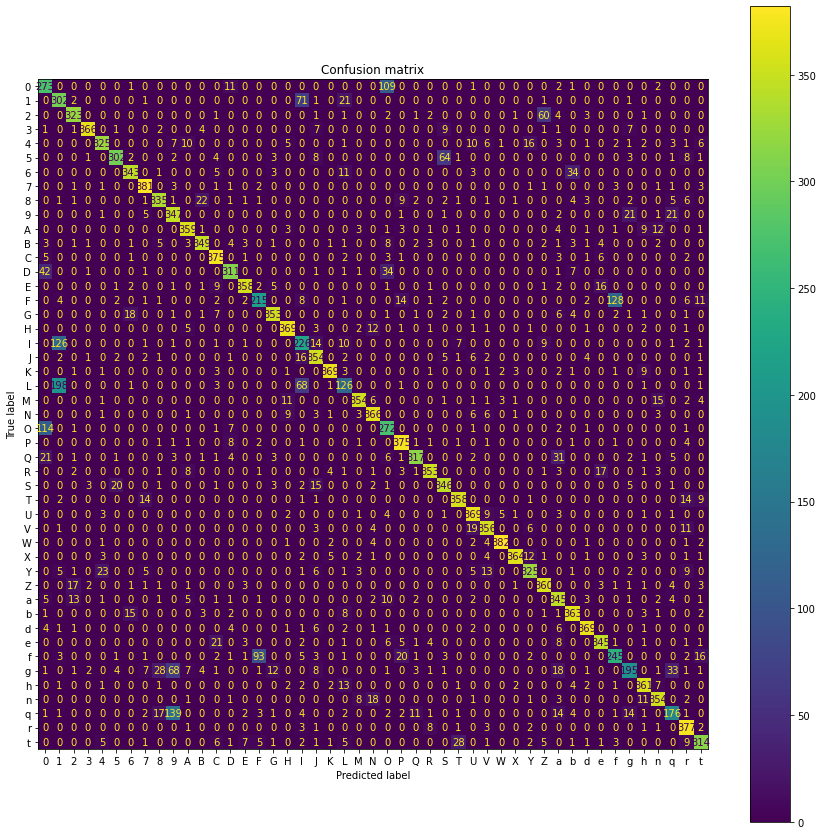

In [53]:
#@title
# DBN + CNN
conf_matr(8, get_accuracy)

Both DBN and DBN+CNN confusion matrices show evident difficulties in distinguish:
- 0 and O,
- 1, I and L,
- 9, g and q,
- F and f.

As it can be seen below, the explanation of those errors can be found in the clear similarity between the images belonging to the different classes. Even humans would have difficulty in distinguishing some of them.

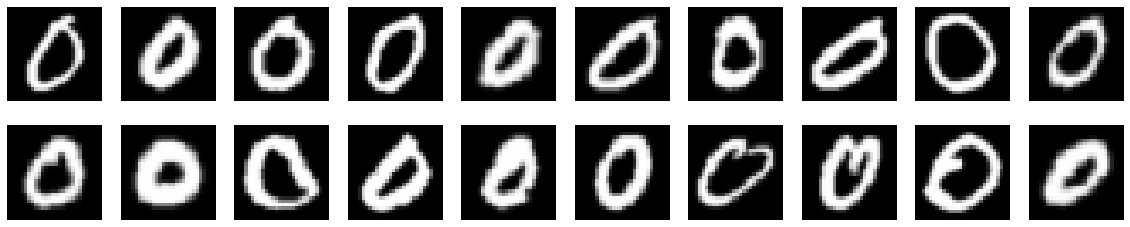

In [54]:
#@title
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in np.arange(10):
  ax[0,i].imshow(torch.transpose(data_train.cpu()[np.where(targ_train.cpu() == 0)[0][i]], 0, 1), cmap=plt.cm.gray)
  ax[0,i].axis('off')
  ax[1,i].imshow(torch.transpose(data_train.cpu()[np.where(targ_train.cpu() == 24)[0][i]], 0, 1), cmap=plt.cm.gray)
  ax[1,i].axis('off')
fig.show()

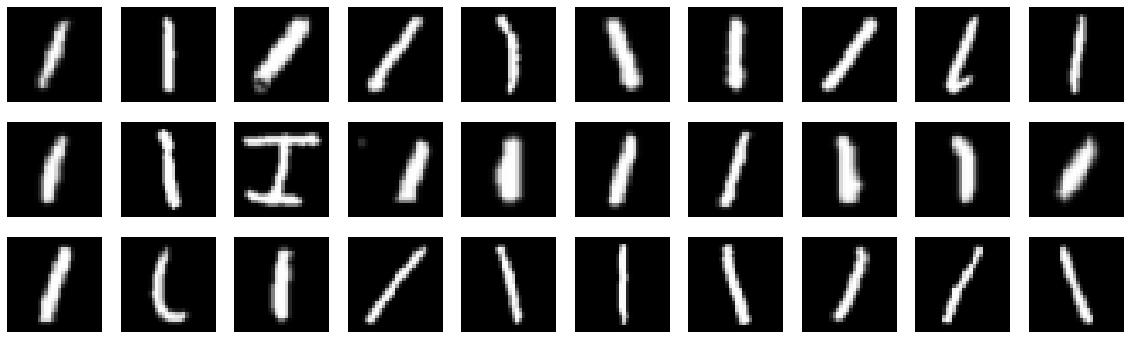

In [55]:
#@title
fig, ax = plt.subplots(3, 10, figsize=(20, 6))
for i in np.arange(10):
  ax[0,i].imshow(torch.transpose(data_train.cpu()[np.where(targ_train.cpu() == 1)[0][i]], 0, 1), cmap=plt.cm.gray)
  ax[0,i].axis('off')
  ax[1,i].imshow(torch.transpose(data_train.cpu()[np.where(targ_train.cpu() == 18)[0][i]], 0, 1), cmap=plt.cm.gray)
  ax[1,i].axis('off')
  ax[2,i].imshow(torch.transpose(data_train.cpu()[np.where(targ_train.cpu() == 21)[0][i]], 0, 1), cmap=plt.cm.gray)
  ax[2,i].axis('off')
fig.show()

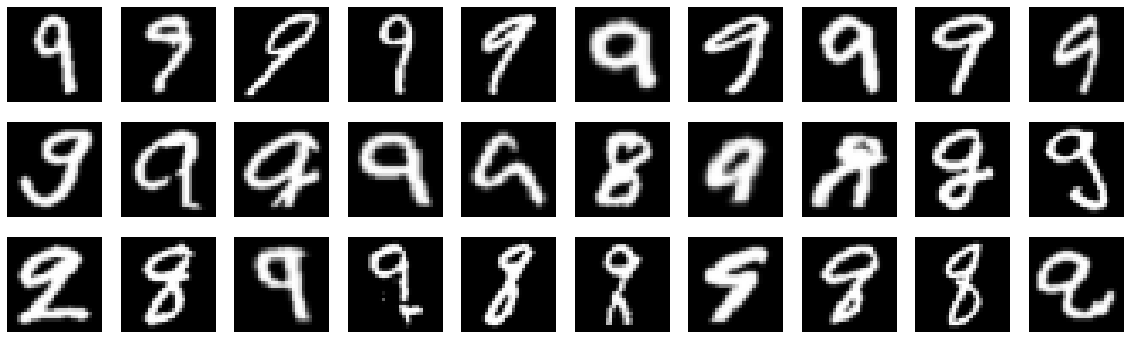

In [56]:
#@title
fig, ax = plt.subplots(3, 10, figsize=(20, 6))
for i in np.arange(10):
  ax[0,i].imshow(torch.transpose(data_train.cpu()[np.where(targ_train.cpu() == 9)[0][i]], 0, 1), cmap=plt.cm.gray)
  ax[0,i].axis('off')
  ax[1,i].imshow(torch.transpose(data_train.cpu()[np.where(targ_train.cpu() == 41)[0][i]], 0, 1), cmap=plt.cm.gray)
  ax[1,i].axis('off')
  ax[2,i].imshow(torch.transpose(data_train.cpu()[np.where(targ_train.cpu() == 44)[0][i]], 0, 1), cmap=plt.cm.gray)
  ax[2,i].axis('off')
fig.show()

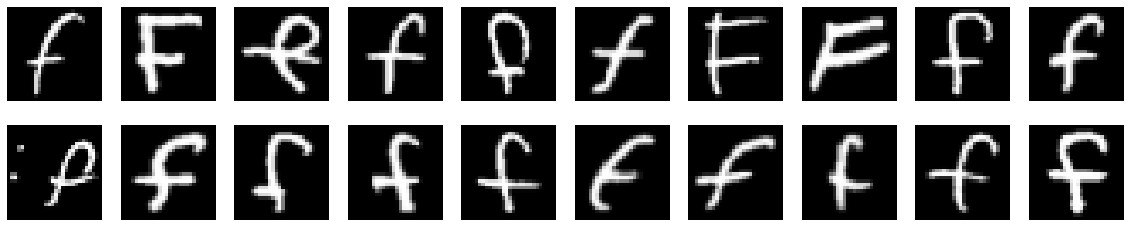

In [57]:
#@title
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in np.arange(10):
  ax[0,i].imshow(torch.transpose(data_train.cpu()[np.where(targ_train.cpu() == 15)[0][i]], 0, 1), cmap=plt.cm.gray)
  ax[0,i].axis('off')
  ax[1,i].imshow(torch.transpose(data_train.cpu()[np.where(targ_train.cpu() == 40)[0][i]], 0, 1), cmap=plt.cm.gray)
  ax[1,i].axis('off')
fig.show()

As regards to the confusion matix of the CNN, it shows that this model can't work properly with noise, CNN is just classifying every example to "B", "Q" and "g".

# Response to adversarial attacks

Finally, the response of models to adversarial attacks is explored.

For the generation of adversarial samples is used the Fast Gradient Sign Method (FGSM): a real input is perturbed in a way that make the loss $J$ for that specific input to increase. The gradient of the loss for an input is calculated, then to the input is added a term $\epsilon \cdot \text{sign}(\nabla J)$, where $\epsilon$ is the strenght of the attack.

## Generation of adversarial samples

-----------------------
**DEEP BELIEF NETWORK**

In [58]:
#@title
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn = dbn
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

dbn_with_readout = DBNWithReadOut(dbn_model, [linear1, linear2, linear3], readout_level=2)

In [59]:
#@title
def fgsm_attack(image, epsilon, data_grad):

    sign_data_grad = data_grad.sign()

    perturbed_image = image + epsilon*sign_data_grad

    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

Let's see what an adversiarial sample for DBN looks like.

One example from the test set is taken and classified using the DBN model previously trained. Then the corresponding adversarial sample is created using FGSM with $\epsilon$=0.2, also classified using the DBN model previously trained.

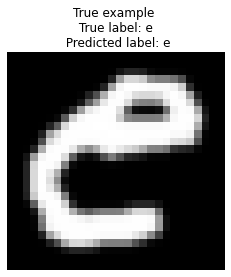

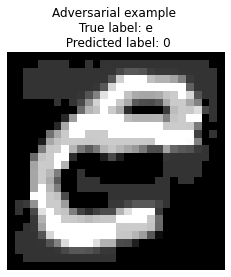

In [60]:
#@title
ind = 1

test_image = data_test[ind].reshape(1, 784)

attacked_model = dbn_with_readout

test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = dataset_labels[torch.argmax(model_outputs)]

plt.imshow(test_image.reshape(28,28).T.to('cpu').detach().numpy(), cmap="gray")
plt.title('True example \n True label: {} \n Predicted label: {}'.format(
    dataset_labels[targ_test[ind]], prediction))
plt.axis('off')
plt.show()


epsilon = 0.2

test_image_label = targ_test[ind].unsqueeze(0)
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
plt.imshow(perturbed_image_np.reshape(28,28).T, cmap="gray")
plt.title('Adversarial example \n True label: {} \n Predicted label: {}'.format(
    dataset_labels[targ_test[ind]], dataset_labels[torch.argmax(model_outputs)]))
plt.axis('off')
plt.show()

--------------------------------
**CONVOLUTIONAL NEURAL NETWORK**

In [61]:
#@title
def fgsm_attack_cnn(data, targets, epsilon):

  data = tf.convert_to_tensor(data.cpu())
  labels = tf.convert_to_tensor(targets.cpu())

  loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

  with tf.GradientTape() as tape:
    tape.watch(data)
    prediction = cnn_model(data)
    loss = loss_function(labels, prediction)

  gradient = tape.gradient(loss, data)
  
  attacked_data = data + epsilon*tf.sign(gradient)
  attacked_data = tf.clip_by_value(attacked_data, -1, 1)

  return attacked_data


Let's see what an adversiarial sample for CNN looks like.

One example from the test set is taken and classified using the CNN model previously trained. Then the corresponding adversarial sample is created using FGSM with $\epsilon$=0.2, also classified using the CNN model previously trained.

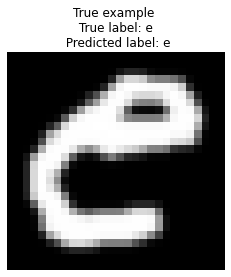

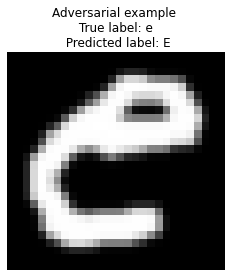

In [62]:
#@title
index = 1
image = tf.convert_to_tensor(data_test[index:index+1].cpu())
label = tf.convert_to_tensor(targ_test[index].cpu())


pred = cnn_model.predict(data_test[index:index+1].cpu().numpy(), verbose=0)
pred_label = np.argmax(pred[0])

plt.figure()
plt.imshow((data_test[index:index+1].cpu().numpy()[0].T)*0.5 + 0.5, cmap='gray')
plt.title('True example \n True label: {} \n Predicted label: {}'.format(
    dataset_labels[targ_test[index]], dataset_labels[pred_label]))
plt.axis('off')
plt.show()


attacked_image = fgsm_attack_cnn(data_test[index:index+1], targ_test[index], 0.2)

pred = cnn_model.predict(attacked_image.numpy(), verbose=0)
pred_label = np.argmax(pred[0])

plt.figure()
plt.imshow((data_test[index:index+1].cpu().numpy()[0].T)*0.5 + 0.5, cmap='gray')
plt.title('Adversarial example \n True label: {} \n Predicted label: {}'.format(
    dataset_labels[targ_test[index]], dataset_labels[pred_label]))
plt.axis('off')
plt.show()

## Resisting to adversarial attacks

Let's now compare the ability of the models to resist to adversarial attacks, simply by evaluating models' performances in classifying the adversarial test set (test set is modified using FGSM).

Below are shown the results obtained testing all models on the test set attacked with strenght $\epsilon$=0.1.

In [63]:
#@title

# DBN and DBN + DBN (num_steps = 1)
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's an original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28).T, cmap="gray")
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's the perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28).T, cmap="gray")
            plt.show()

        # If requested, reconstruct the input iterating forward-backward dynamics (DBN+DBN)
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what the {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28).T, cmap="gray")
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()


# CNN
def test_robustness_to_attack_cnn(model, device, test_loader, epsilon):
    correct = 0

    for data, target in tqdm(test_loader):

        data = torch.flatten(data, 1, 2)
        perturbed_data = fgsm_attack_cnn(data, target, epsilon)

        # Re-classify the perturbed image
        output = model.predict(perturbed_data.numpy(), verbose=0)

        # Check for success
        # get the index of the max element in the output
        final_pred = np.argmax(output, axis=1)
        correct += (final_pred == np.array(target)).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()


# DBN + CNN
def test_robustness_to_attack_dbncnn(model, device, test_loader, epsilon):
    correct = 0

    for data, target in tqdm(test_loader):

        data = torch.flatten(data, 1, 2)
        perturbed_data = fgsm_attack_cnn(data, target, epsilon)

        # reconstruct images with dbn
        perturbed_data_flat = torch.Tensor(np.array(perturbed_data).reshape((data.shape[0], 28, 28))).reshape(-1, 784)
        reconstructed_data = dbn_model.reconstruct(perturbed_data_flat)[0].reshape(data.shape[0], 28, 28)

        # Re-classify the perturbed image
        output = model.predict(reconstructed_data.cpu().detach().numpy(), verbose=0)

        # Check for success
        # get the index of the max element in the output
        final_pred = np.argmax(output, axis=1)
        correct += (final_pred == np.array(target)).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [64]:
#@title
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('data/', split='balanced', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [65]:
#@title
print("FFNN")
final_acc_ffnn = test_robustness_to_attack(ffnn_model, device, test_loader, epsilon=0.1, num_steps=0)
print("-------------------------------------------")

print("DBN")
final_acc_dbn = test_robustness_to_attack(dbn_with_readout, device, test_loader, epsilon=0.1, num_steps=0)
print("-------------------------------------------")

print("DBN + DBN (DBN top-down)")
final_acc_dbndbn = test_robustness_to_attack(dbn_with_readout, device, test_loader, epsilon=0.1, num_steps=1, verbose=False)
print("-------------------------------------------")

print("CNN")
final_acc_cnn = test_robustness_to_attack_cnn(cnn_model, device, test_loader, epsilon=0.1)
print("-------------------------------------------")

print("DBN + CNN")
final_acc_dbncnn = test_robustness_to_attack_dbncnn(cnn_model, device, test_loader, epsilon=0.1)

FFNN


  0%|          | 0/188 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 19.41%

-------------------------------------------
DBN


  0%|          | 0/188 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 47.27%

-------------------------------------------
DBN + DBN (DBN top-down)


  0%|          | 0/188 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 51.69%

-------------------------------------------
CNN


  0%|          | 0/188 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 43.35%

-------------------------------------------
DBN + CNN


  0%|          | 0/188 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 81.05%



Finally, let's compare the robustness of each model to adversarial attacks of different strengths.

In [66]:
#@title
%%capture
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()
  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)
  return accuracies

def test_epsilon_values_effect_cnn(model):
  accuracies = list()
  for eps in epsilon_values:
      acc = test_robustness_to_attack_cnn(model, device, test_loader, eps)
      accuracies.append(acc)
  return accuracies

def test_epsilon_values_effect_dbncnn(model):
  accuracies = list()
  for eps in epsilon_values:
      acc = test_robustness_to_attack_dbncnn(model, device, test_loader, eps)
      accuracies.append(acc)
  return accuracies

accuracies_ffnn = test_epsilon_values_effect(ffnn_model, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)
accuracies_cnn = test_epsilon_values_effect_cnn(cnn_model)
accuracies_dbncnn = test_epsilon_values_effect_dbncnn(cnn_model)

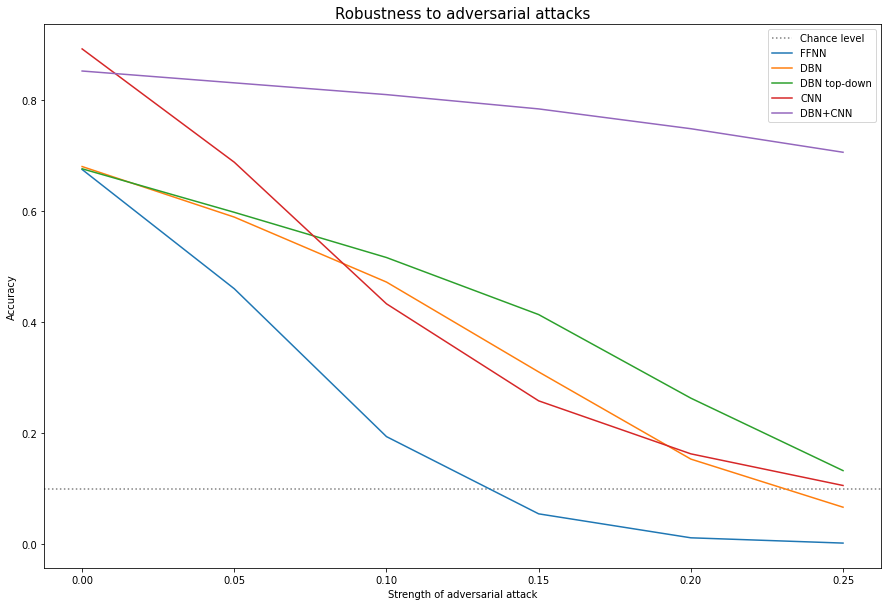

In [67]:
#@title
fig, ax = plt.subplots(1, 1, figsize=(15, 10), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.plot(epsilon_values, accuracies_cnn)
__ = ax.plot(epsilon_values, accuracies_dbncnn)
__ = ax.set_xlabel("Strength of adversarial attack")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down", "CNN", "DBN+CNN"])

Definitely the DBN + CNN model has the best performances, it is robust for adversarial attacks and for noised input. This was the goal of the project.

The CNN model alone works better when classifying adversarial examples rather than noised examples. With stronger attacks its performance is comparable to DBN and DBN + DBN performances.